## 전이 학습
문제 A를 해결하면서 얻은 지식 및 경험을 문제 B에 적용하는 과정  
* 특성 추출  
    * 합성곱층 : 합성곱과 풀링층으로 구성
    * 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스르 분류하는 기준
* 미세 조정 기법

In [1]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import tensorflow_hub as hub

from matplotlib import font_manager             # 한글 적용 시킬 때 사용..!
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalMaxPool2D, GlobalAveragePooling2D   # 완전연결층, 최댓값풀링, 평균값풀링
from tensorflow.keras.models import Sequential                                       # 순차적으로 쌓는 모델
from tensorflow.keras.applications import ResNet50                                   # 가중치가 선행 학습된 모델
from tensorflow.keras.preprocessing.image import ImageDataGenerator                  # 크기가 다른 이미지 파일 동일한 크기로 편집

In [2]:
# 사전 훈련된 모델 내려받기
model = ResNet50(include_top = True,         # 네트워크 상단에 완전연결층 포함 여부
                 weights = 'imagenet',        # 가중치(None / imagenet : ImageNet에서 사전 훈련된 값)
                 input_tensor = None,        # 입력 데이터의 텐서
                 input_shape = None,         # 입력 이미지에 대한 텐서 크기
                 pooling = None,             # None(마지막 합성곱층 출력), avg(마지막 합성곱층에 평균 풀링 추가), max(최대 풀링 추가)
                 classes = 1000)              # weights = 'imagenet' 이면 1000으로, 아니면 None으로

# ResNet50 네트워크 구조
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
# ResNet50 네트워크에 밀집층 추가
model.trainable = False
model = Sequential([model, Dense(2, activation = 'sigmoid')])     # model에 dense 추가
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense (Dense)                (None, 2)                 2002      
Total params: 25,638,714
Trainable params: 2,002
Non-trainable params: 25,636,712
_________________________________________________________________


In [4]:
# 환경 설정
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [5]:
# 모델 훈련
BATCH_SIZE = 32
image_height = 224
image_width = 224
train_dir = 'C:/AI/catanddog/train'
valid_dir = 'C:/AI/catanddog/validation'

# 이미지 변형 (데이터의 양이 적을 때) => 같은 데이터를 여러 각도, 방향, 위치에서 훈련시켜 데이터 수를 늘림
train = ImageDataGenerator(                     
                    rescale = 1./255.,          # 정규화 (안하면 0~255 값으로 나옴(픽셀값))
                    rotation_range = 10,        # 0~10도 범위내에서 원본 이미지 회전
                    width_shift_range = 0.1,    # 10% 비율내에서 수평으로 랜덤하게 평행 이동
                    height_shift_range = 0.1,   # 10% 비율내에서 수직으로 랜덤하게 평행 이동
                    shear_range = 0.1,          # 10% 비율내에서 원본 이미지를 임의로 변형
                    zoom_range = 0.1)           # 0.9~1.1배의 크기로 임의 확대/축소

valid = ImageDataGenerator(rescale = 1./255.)   # 검증용 데이터이기 때문에 변형 불필요.. 정규화만 !!

# 폴더 구조를 가져와서 실제 데이터를 ImageDataGenerator에 채워줌
# 이미지 정보를 포함하고 있지 않음, 설정만 해둔 상태.
train_generator = train.flow_from_directory(train_dir,                                  # 파일 위치
                                            target_size = (image_height, image_width),  # 크기
                                            color_mode = 'rgb',                         # 'grayscale':흑백, 'rgb':색상
                                            batch_size = BATCH_SIZE,                    # 배치당 생성할 이미지 개수
                                            seed = 1,                                   # 난수 랜덤한 값
                                            shuffle = True,                             # 섞기
                                            class_mode = 'categorical')                 # 'binary':클래스 2개, 'categorical':그 이상

valid_generator = valid.flow_from_directory(valid_dir,                                  
                                            target_size = (image_height, image_width),  
                                            color_mode = 'rgb',                         
                                            batch_size = BATCH_SIZE,                    
                                            seed = 7,                                   
                                            shuffle = True,                             
                                            class_mode = 'categorical')                 

# Found 385 images belonging to 2 classes. : 385개의 이미지가 있고 클래스 2개
# Found 98 images belonging to 2 classes. : 98개의 이미지가 있고 클래스 2개

# 모델 훈련시키기 위한 파라미터
history = model.fit(train_generator,                          # 학습 데이터셋
                    epochs = 10,                              # 학습 반복횟수
                    validation_data = valid_generator,        # 테스트 데이터셋
                    verbose = 2)                              # 진행과정 출력 (0:출력x, 1:진행막대, 2:배치마다 훈련정보)

# 1000개 - 2개 사이에서 가중치 갱신 이루어짐..

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
13/13 - 22s - loss: 0.6935 - accuracy: 0.4727 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
13/13 - 20s - loss: 0.6935 - accuracy: 0.4727 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
13/13 - 20s - loss: 0.6935 - accuracy: 0.4727 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
13/13 - 20s - loss: 0.6935 - accuracy: 0.4727 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
13/13 - 20s - loss: 0.6932 - accuracy: 0.5039 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
13/13 - 20s - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
13/13 - 20s - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/10
13/13 - 22s - loss: 0.6929 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 9/10
13/13 - 20s - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 10/10
13/13 - 20s - lo

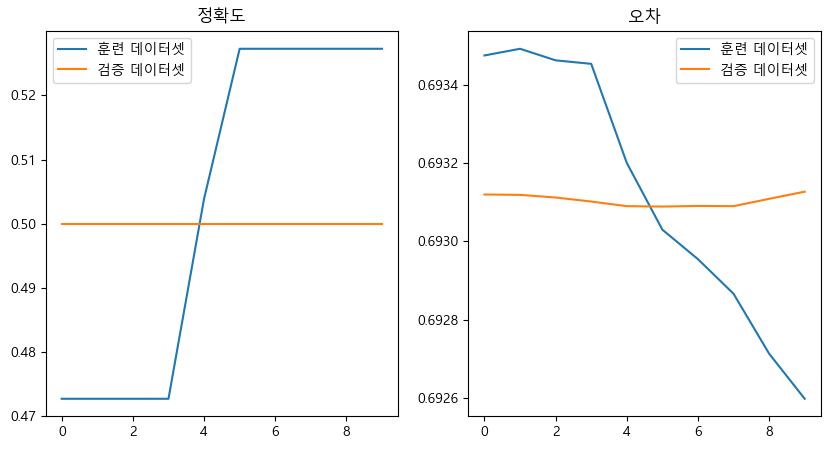

In [6]:
# 모델의 정확도 시각화

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams['font.family'] = font_family        # 글꼴 적용

accuracy = history.history['accuracy']           # 훈련 정확도 추출
val_accuracy = history.history['val_accuracy']   # 검증 정확도 추출

loss = history.history['loss']                   # 훈련 오차 추출
val_loss = history.history['val_loss']           # 검증 오차 추출

epochs = range(len(accuracy))                    # 0~9

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, accuracy, label='훈련 데이터셋')
plt.plot(epochs, val_accuracy, label='검증 데이터셋')
plt.legend()
plt.title('정확도')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='훈련 데이터셋')
plt.plot(epochs, val_loss, label='검증 데이터셋')
plt.legend()
plt.title('오차')

plt.show()

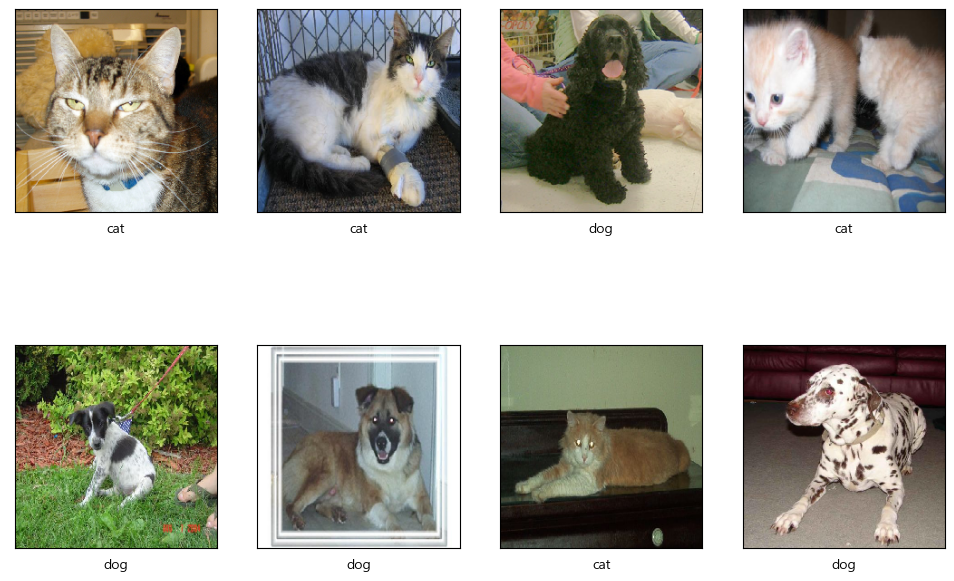

In [7]:
class_names = ['cat', 'dog']
validation, label_batch = next(iter(valid_generator))      # 반복(반복자(리스트 반환 가능 객체)), 
prediction_values = np.argmax(model.predict(validation), axis=-1)   # 검증데이터를 이용해서 예측 
prediction_value = np.argmax(prediction_values, axis=0)

fig = plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(validation[i])
    plt.xticks([])
    plt.yticks([])
    if prediction_values[i] == np.argmax(label_batch[i]):
        plt.xlabel(class_names[prediction_values[i]])
    else :
        plt.xlabel(class_names[1 - prediction_values[i]])
    
plt.show()

## 텐서플로 허브

In [2]:
model = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
                      input_shape = (224,224,3),
                      trainable = False),
        tf.keras.layers.Dense(2, activation = 'softmax')
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [3]:
# 모델 훈련
BATCH_SIZE = 32
image_height = 224
image_width = 224
train_dir = 'C:/AI/catanddog/train'
valid_dir = 'C:/AI/catanddog/validation'

# 이미지 변형 (데이터의 양이 적을 때) => 같은 데이터를 여러 각도, 방향, 위치에서 훈련시켜 데이터 수를 늘림
train = ImageDataGenerator(                     
                    rescale = 1./255.,          # 정규화 (안하면 0~255 값으로 나옴(픽셀값))
                    rotation_range = 10,        # 0~10도 범위내에서 원본 이미지 회전
                    width_shift_range = 0.1,    # 10% 비율내에서 수평으로 랜덤하게 평행 이동
                    height_shift_range = 0.1,   # 10% 비율내에서 수직으로 랜덤하게 평행 이동
                    shear_range = 0.1,          # 10% 비율내에서 원본 이미지를 임의로 변형
                    zoom_range = 0.1)           # 0.9~1.1배의 크기로 임의 확대/축소

valid = ImageDataGenerator(rescale = 1./255.)   # 검증용 데이터이기 때문에 변형 불필요.. 정규화만 !!

# 폴더 구조를 가져와서 실제 데이터를 ImageDataGenerator에 채워줌
# 이미지 정보를 포함하고 있지 않음, 설정만 해둔 상태.
train_generator = train.flow_from_directory(train_dir,                                  # 파일 위치
                                            target_size = (image_height, image_width),  # 크기
                                            color_mode = 'rgb',                         # 'grayscale':흑백, 'rgb':색상
                                            batch_size = BATCH_SIZE,                    # 배치당 생성할 이미지 개수
                                            seed = 1,                                   # 난수 랜덤한 값
                                            shuffle = True,                             # 섞기
                                            class_mode = 'categorical')                 # 'binary':클래스 2개, 'categorical':그 이상

valid_generator = valid.flow_from_directory(valid_dir,                                  
                                            target_size = (image_height, image_width),  
                                            color_mode = 'rgb',                         
                                            batch_size = BATCH_SIZE,                    
                                            seed = 7,                                   
                                            shuffle = True,                             
                                            class_mode = 'categorical')                 

# Found 385 images belonging to 2 classes. : 385개의 이미지가 있고 클래스 2개
# Found 98 images belonging to 2 classes. : 98개의 이미지가 있고 클래스 2개

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

Found 385 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [4]:
history = model.fit(train_generator,                          # 학습 데이터셋
                    epochs = 10,                              # 학습 반복횟수
                    validation_data = valid_generator,        # 테스트 데이터셋
                    verbose = 2)                              # 진행과정 출력 (0:출력x, 1:진행막대, 2:배치마다 훈련정보)

Epoch 1/10
13/13 - 46s - loss: 0.4778 - accuracy: 0.8130 - val_loss: 0.1033 - val_accuracy: 0.9796
Epoch 2/10
13/13 - 47s - loss: 0.1096 - accuracy: 0.9610 - val_loss: 0.0406 - val_accuracy: 0.9898
Epoch 3/10
13/13 - 44s - loss: 0.0572 - accuracy: 0.9818 - val_loss: 0.0380 - val_accuracy: 0.9898
Epoch 4/10
13/13 - 45s - loss: 0.0283 - accuracy: 0.9948 - val_loss: 0.0276 - val_accuracy: 0.9898
Epoch 5/10
13/13 - 47s - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9898
Epoch 6/10
13/13 - 48s - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0258 - val_accuracy: 0.9898
Epoch 7/10
13/13 - 46s - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.0258 - val_accuracy: 0.9898
Epoch 8/10
13/13 - 45s - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.0252 - val_accuracy: 0.9898
Epoch 9/10
13/13 - 49s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9898
Epoch 10/10
13/13 - 48s - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9898
